<a href="https://colab.research.google.com/github/seungmei/QNS/blob/main/Fe_PTCDA_Huckel_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔬 Fe/PTCDA Hückel Model — Orbital Shift Simulator

**Hückel theory framework for understanding HOMO peak shifts in metal/PTCDA systems**

This notebook models how Fe adatoms cause orbital energy shifts in PTCDA through two mechanisms:
1. **Delocalization** (β mixing): Fe d-orbital hybridization with PTCDA π-system
2. **Electrostatic interaction** (Δα): Coulomb potential from Fe partial charge shifting on-site energies

---

**Reference context:**
- Ag atoms: physisorption → weak interaction, minimal orbital shifts
- Fe atoms: chemisorption → strong orbital mixing + electrostatic → significant HOMO shifts observable in UPS

---

## 1. Setup & Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import FancyArrowPatch
from scipy.signal import find_peaks
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import warnings
warnings.filterwarnings('ignore')

# Style setup
plt.rcParams.update({
    'figure.facecolor': '#0a0f1a',
    'axes.facecolor': '#0f172a',
    'axes.edgecolor': '#334155',
    'axes.labelcolor': '#94a3b8',
    'text.color': '#e2e8f0',
    'xtick.color': '#64748b',
    'ytick.color': '#64748b',
    'grid.color': '#1e293b',
    'grid.alpha': 0.5,
    'font.size': 11,
    'font.family': 'sans-serif',
})

print('✅ Setup complete.')

✅ Setup complete.


## 2. PTCDA Topology Definition

PTCDA (C₂₄H₈O₆) π-system:
- 20 perylene core carbons (atoms 0–19)
- 4 carbonyl carbons (atoms 20–23)
- 4 carbonyl oxygens =O (atoms 24–27, pyridine-type: 1 e⁻ each)
- 2 bridge oxygens -O- (atoms 28–29, pyrrole-type: 2 e⁻ each)
- **Total: 30 atoms, 32 π-electrons**

In [2]:
# ============================================================
# PTCDA Topology
# ============================================================

N_PTCDA = 30
N_ELECTRONS_PTCDA = 32

# --- Bond lists ---
# Perylene core (20 C atoms)
# Naph1: Ring A (0-1-2-3-4-9), Ring B (4-5-6-7-8-9)
# Naph2: Ring C (10-11-12-13-14-19), Ring D (14-15-16-17-18-19)
# Peri-fusion: Ring E (0-9-8-18-19-10)
PERYLENE_BONDS = [
    (0,1),(1,2),(2,3),(3,4),(4,9),(4,5),(5,6),(6,7),(7,8),(8,9),(9,0),
    (10,11),(11,12),(12,13),(13,14),(14,19),(14,15),(15,16),(16,17),(17,18),(18,19),(19,10),
    (0,10),(8,18),
]

# Anhydride C-C bonds (carbonyl C to perylene C)
# Anhydride 1: fused at bond (5,6); Anhydride 2: fused at bond (15,16)
ANHYDRIDE_CC = [(5,20),(6,21),(15,22),(16,23)]

# Carbonyl C=O bonds
ANHYDRIDE_CO_DBL = [(20,24),(21,25),(22,26),(23,27)]

# Bridge C-O bonds (ether type)
ANHYDRIDE_CO_SGL = [(20,28),(21,28),(22,29),(23,29)]

# --- Hückel parameters (Streitwieser) ---
H_PARAMS = {
    'h_C': 0.0,           # Carbon on-site
    'h_O_carbonyl': 1.0,  # Carbonyl O (=O)
    'h_O_bridge': 2.0,    # Bridge O (-O-)
    'k_CC': 1.0,          # C-C resonance integral ratio
    'k_CO_dbl': 1.0,      # C=O resonance integral ratio
    'k_CO_sgl': 0.8,      # C-O (ether) resonance integral ratio
}

# Atom labels
ATOM_LABELS = (
    [f'C{i}' for i in range(20)] +
    ['C20(C=O)','C21(C=O)','C22(C=O)','C23(C=O)'] +
    ['O24(=O)','O25(=O)','O26(=O)','O27(=O)'] +
    ['O28(-O-)','O29(-O-)']
)

# Atom types for coloring
ATOM_TYPES = (
    ['pery_C']*20 + ['carb_C']*4 + ['carb_O']*4 + ['bridge_O']*2
)

# Atoms affected by electrostatic shift (near anhydride region)
ELECTROSTATIC_ATOMS = [5,6,15,16, 20,21,22,23, 24,25,26,27]

print(f'PTCDA: {N_PTCDA} atoms, {N_ELECTRONS_PTCDA} π-electrons')
print(f'Bonds: {len(PERYLENE_BONDS)} (perylene) + {len(ANHYDRIDE_CC)} (CC) + '
      f'{len(ANHYDRIDE_CO_DBL)} (C=O) + {len(ANHYDRIDE_CO_SGL)} (C-O) = '
      f'{len(PERYLENE_BONDS)+len(ANHYDRIDE_CC)+len(ANHYDRIDE_CO_DBL)+len(ANHYDRIDE_CO_SGL)} total')

PTCDA: 30 atoms, 32 π-electrons
Bonds: 24 (perylene) + 4 (CC) + 4 (C=O) + 4 (C-O) = 36 total


## 3. Hückel Matrix Builder & Solver

In [3]:
def build_ptcda_matrix(delta_alpha=0.0, affected_atoms=None):
    """
    Build the 30x30 Hückel matrix for bare PTCDA.

    Parameters
    ----------
    delta_alpha : float
        Electrostatic shift applied to affected atoms (in units of β).
        Positive = stabilization (lower energy, since β < 0).
    affected_atoms : list of int, optional
        Atom indices to apply delta_alpha to.

    Returns
    -------
    H : ndarray (30, 30)
    """
    if affected_atoms is None:
        affected_atoms = []

    H = np.zeros((N_PTCDA, N_PTCDA))

    # Diagonal: heteroatom Coulomb integrals
    for i in range(24, 28):
        H[i, i] = H_PARAMS['h_O_carbonyl']
    for i in [28, 29]:
        H[i, i] = H_PARAMS['h_O_bridge']

    # Electrostatic shift
    for idx in affected_atoms:
        if idx < N_PTCDA:
            H[idx, idx] += delta_alpha

    # Off-diagonal: resonance integrals
    for i, j in PERYLENE_BONDS:
        H[i, j] = H[j, i] = H_PARAMS['k_CC']
    for i, j in ANHYDRIDE_CC:
        H[i, j] = H[j, i] = H_PARAMS['k_CC']
    for i, j in ANHYDRIDE_CO_DBL:
        H[i, j] = H[j, i] = H_PARAMS['k_CO_dbl']
    for i, j in ANHYDRIDE_CO_SGL:
        H[i, j] = H[j, i] = H_PARAMS['k_CO_sgl']

    return H


def build_metal_ptcda_matrix(alpha_fe, beta_fe_o, delta_alpha, n_fe,
                              binding_sites=None):
    """
    Build the extended Hückel matrix for Metal/PTCDA system.

    Parameters
    ----------
    alpha_fe : float
        Fe on-site energy (Coulomb integral), in units of β relative to α_C.
    beta_fe_o : float
        Fe-O resonance integral ratio (coupling strength).
    delta_alpha : float
        Electrostatic shift on nearby PTCDA atoms.
    n_fe : int
        Number of Fe atoms.
    binding_sites : list of lists, optional
        binding_sites[f] = list of PTCDA atom indices that Fe atom f bonds to.
        Default: Fe atoms bond to carbonyl oxygens.

    Returns
    -------
    H : ndarray (N, N)
    N : int (total size)
    """
    if n_fe == 0:
        H = build_ptcda_matrix(delta_alpha, ELECTROSTATIC_ATOMS if delta_alpha != 0 else [])
        return H, N_PTCDA

    # Default binding sites: Fe → carbonyl oxygens
    if binding_sites is None:
        if n_fe == 1:
            binding_sites = [[24, 25]]  # Fe bonds to anhydride 1 oxygens
        elif n_fe == 2:
            binding_sites = [[24, 25], [26, 27]]  # one Fe per anhydride
        elif n_fe == 4:
            binding_sites = [[24], [25], [26], [27]]  # one Fe per O
        else:
            binding_sites = [[24, 25]] * n_fe

    N = N_PTCDA + n_fe
    H = np.zeros((N, N))

    # PTCDA block
    electro_atoms = ELECTROSTATIC_ATOMS if delta_alpha != 0 else []
    H[:N_PTCDA, :N_PTCDA] = build_ptcda_matrix(delta_alpha, electro_atoms)

    # Fe atoms
    for f in range(n_fe):
        fe_idx = N_PTCDA + f
        H[fe_idx, fe_idx] = alpha_fe
        if f < len(binding_sites):
            for site in binding_sites[f]:
                H[fe_idx, site] = beta_fe_o
                H[site, fe_idx] = beta_fe_o

    return H, N


def solve_huckel(H, n_electrons):
    """
    Solve the Hückel secular equation H·c = x·c.

    Returns dict with eigenvalues (sorted descending = lowest energy first),
    eigenvectors, occupation info, and charge densities.
    """
    eigenvalues, eigenvectors = np.linalg.eigh(H)

    # Sort descending (most positive x = lowest energy, since β < 0)
    idx = np.argsort(-eigenvalues)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    n_occ = n_electrons // 2

    # Charge density
    charge = np.zeros(len(eigenvalues))
    for k in range(n_occ):
        charge += 2 * eigenvectors[:, k]**2

    return {
        'eigenvalues': eigenvalues,
        'eigenvectors': eigenvectors,
        'n_occ': n_occ,
        'n_electrons': n_electrons,
        'charge': charge,
        'homo_idx': n_occ - 1,
        'lumo_idx': n_occ,
        'homo_energy': eigenvalues[n_occ - 1],
        'lumo_energy': eigenvalues[n_occ],
        'gap': eigenvalues[n_occ - 1] - eigenvalues[n_occ],
    }

# Quick test
bare = solve_huckel(build_ptcda_matrix(), N_ELECTRONS_PTCDA)
print(f'Bare PTCDA:')
print(f'  HOMO = α + ({bare["homo_energy"]:.4f})β')
print(f'  LUMO = α + ({bare["lumo_energy"]:.4f})β')
print(f'  Gap  = {bare["gap"]:.4f}|β|')

Bare PTCDA:
  HOMO = α + (0.4263)β
  LUMO = α + (-0.0040)β
  Gap  = 0.4303|β|


## 4. Visualization Functions

In [4]:
def plot_energy_levels(results_dict, ax=None, title='Energy Levels'):
    """
    Plot MO energy level diagram for multiple systems side by side.

    Parameters
    ----------
    results_dict : dict
        {label: result_dict} where result_dict is from solve_huckel()
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))

    n_cols = len(results_dict)
    colors = ['#64748b', '#a78bfa', '#f59e0b', '#22c55e', '#ef4444', '#3b82f6']

    col_width = 0.6
    gap = 0.3
    total_w = n_cols * col_width + (n_cols - 1) * gap
    x_start = -total_w / 2

    for ci, (label, res) in enumerate(results_dict.items()):
        x_center = x_start + ci * (col_width + gap) + col_width / 2
        x_left = x_center - col_width / 2
        x_right = x_center + col_width / 2
        color = colors[ci % len(colors)]

        # Show at most 30 levels (PTCDA-derived)
        n_show = min(len(res['eigenvalues']), 34)

        for k in range(n_show):
            e = res['eigenvalues'][k]
            is_occ = k < res['n_occ']
            is_homo = k == res['homo_idx']
            is_lumo = k == res['lumo_idx']
            lw = 2.5 if (is_homo or is_lumo) else 0.8
            alpha = 0.9 if is_occ else 0.4

            ax.hlines(e, x_left, x_right, colors=color, linewidth=lw, alpha=alpha)

            if is_homo:
                ax.annotate('H', (x_right + 0.03, e), color=color, fontsize=8,
                           fontweight='bold', va='center')
            if is_lumo:
                ax.annotate('L', (x_right + 0.03, e), color='#ef4444', fontsize=8,
                           fontweight='bold', va='center')

        ax.text(x_center, ax.get_ylim()[0] if ax.get_ylim()[0] != 0 else -3.3,
                label, ha='center', va='top', color=color, fontsize=10, fontweight='bold')

    ax.axhline(y=0, color='#475569', linestyle='--', linewidth=0.5, alpha=0.5)
    ax.set_ylabel('Energy (α + xβ)', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold', pad=10)
    ax.set_xticks([])
    ax.grid(True, axis='y', alpha=0.3)
    ax.set_ylim(-3.2, 3.2)

    return ax


def plot_simulated_spectrum(results_dict, beta_eV=-2.4, sigma=0.25,
                            ax=None, title='Simulated Photoemission'):
    """
    Simulated UPS-like spectrum (Gaussian-broadened occupied DOS).
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 3))

    e_range = np.linspace(-12, 3, 500)
    colors = ['#64748b', '#a78bfa', '#f59e0b', '#22c55e', '#ef4444', '#3b82f6']

    for ci, (label, res) in enumerate(results_dict.items()):
        dos = np.zeros_like(e_range)
        for k in range(res['n_occ']):
            ek = res['eigenvalues'][k] * beta_eV
            dos += np.exp(-0.5 * ((e_range - ek) / sigma)**2)

        color = colors[ci % len(colors)]
        lw = 2.0 if ci > 0 else 1.5
        ax.plot(e_range, dos, color=color, linewidth=lw, label=label, alpha=0.85)

        # HOMO marker
        homo_be = res['homo_energy'] * beta_eV
        ax.axvline(homo_be, color=color, linestyle=':', linewidth=1, alpha=0.5)

    ax.set_xlabel('Binding Energy (eV, relative to α)', fontsize=11)
    ax.set_ylabel('Intensity (a.u.)', fontsize=11)
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.legend(fontsize=9, loc='upper left', framealpha=0.3)
    ax.set_xlim(-10, 2)
    ax.grid(True, alpha=0.2)

    return ax


def plot_wavefunction(result, mo_index, n_ptcda=30, n_fe=0, ax=None, title=None):
    """
    Bar plot of |c_r|² for a given MO.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 2.5))

    vec = result['eigenvectors'][:, mo_index]
    N = len(vec)
    prob = vec**2

    # Colors by atom type
    colors = []
    for i in range(N):
        if i < 20:   colors.append('#3b82f6')    # perylene C
        elif i < 24: colors.append('#10b981')    # carbonyl C
        elif i < 28: colors.append('#f59e0b')    # carbonyl O
        elif i < 30: colors.append('#f97316')    # bridge O
        else:        colors.append('#ef4444')    # Fe

    ax.bar(range(N), prob, color=colors, edgecolor='none', width=0.8)

    is_homo = mo_index == result['homo_idx']
    is_lumo = mo_index == result['lumo_idx']
    mo_label = 'HOMO' if is_homo else ('LUMO' if is_lumo else f'MO #{mo_index+1}')

    if title is None:
        title = f'{mo_label}: E = α + ({result["eigenvalues"][mo_index]:.4f})β'
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_xlabel('Atom index', fontsize=10)
    ax.set_ylabel('|c_r|²', fontsize=10)

    # Region annotations
    ax.text(10, ax.get_ylim()[1]*0.85, 'Perylene C', fontsize=8, ha='center', color='#3b82f6')
    if N > 30:
        ax.text(N-1-n_fe//2, ax.get_ylim()[1]*0.85, 'Fe', fontsize=8, ha='center', color='#ef4444')

    ax.grid(True, axis='y', alpha=0.2)
    return ax


def plot_charge_distribution(result, n_ptcda=30, n_fe=0, ax=None):
    """
    Bar plot of π-electron charge density.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 3))

    charge = result['charge']
    N = len(charge)

    colors = []
    for i in range(N):
        if i < 20:   colors.append('#3b82f6')
        elif i < 24: colors.append('#10b981')
        elif i < 28: colors.append('#f59e0b')
        elif i < 30: colors.append('#f97316')
        else:        colors.append('#ef4444')

    ax.bar(range(N), charge, color=colors, edgecolor='none', width=0.8)
    ax.axhline(y=1.0, color='#475569', linestyle='--', linewidth=0.8, alpha=0.5, label='Neutral C (1.0)')
    ax.set_xlabel('Atom index', fontsize=10)
    ax.set_ylabel('π-electron density', fontsize=10)
    ax.set_title('Charge Distribution', fontsize=12, fontweight='bold')
    ax.legend(fontsize=8, framealpha=0.3)
    ax.grid(True, axis='y', alpha=0.2)

    return ax

print('✅ Visualization functions defined.')

✅ Visualization functions defined.


## 5. Bare PTCDA — Baseline Calculation

First, let's establish the reference: the bare PTCDA molecule without any metal adatoms.

In [5]:
# Solve bare PTCDA
bare_result = solve_huckel(build_ptcda_matrix(), N_ELECTRONS_PTCDA)

print('=' * 60)
print('BARE PTCDA — Hückel Results')
print('=' * 60)
print(f'  Total MOs:    {len(bare_result["eigenvalues"])}')
print(f'  Occupied:     {bare_result["n_occ"]} (32 electrons / 2)')
print(f'  HOMO (MO #16): E = α + ({bare_result["homo_energy"]:.4f})β')
print(f'  LUMO (MO #17): E = α + ({bare_result["lumo_energy"]:.4f})β')
print(f'  HOMO-LUMO gap: {bare_result["gap"]:.4f}|β|')
print()
print('Energy levels:')
print(f'{"MO":>4} {"x (α+xβ)":>12} {"Occ":>6} {"Label":>8}')
print('-' * 34)
for k in range(len(bare_result['eigenvalues'])):
    e = bare_result['eigenvalues'][k]
    occ = '↑↓' if k < bare_result['n_occ'] else '  '
    label = '← HOMO' if k == bare_result['homo_idx'] else ('← LUMO' if k == bare_result['lumo_idx'] else '')
    print(f'{k+1:>4} {e:>+12.4f} {occ:>6} {label:>8}')

BARE PTCDA — Hückel Results
  Total MOs:    30
  Occupied:     16 (32 electrons / 2)
  HOMO (MO #16): E = α + (0.4263)β
  LUMO (MO #17): E = α + (-0.0040)β
  HOMO-LUMO gap: 0.4303|β|

Energy levels:
  MO     x (α+xβ)    Occ    Label
----------------------------------
   1      +2.8538     ↑↓         
   2      +2.8295     ↑↓         
   3      +2.5357     ↑↓         
   4      +2.1621     ↑↓         
   5      +1.9125     ↑↓         
   6      +1.7805     ↑↓         
   7      +1.7792     ↑↓         
   8      +1.6166     ↑↓         
   9      +1.6045     ↑↓         
  10      +1.3262     ↑↓         
  11      +1.2845     ↑↓         
  12      +1.0000     ↑↓         
  13      +1.0000     ↑↓         
  14      +1.0000     ↑↓         
  15      +1.0000     ↑↓         
  16      +0.4263     ↑↓   ← HOMO
  17      -0.0040          ← LUMO
  18      -0.2073                
  19      -0.5463                
  20      -0.8367                
  21      -0.8671                
  22      -1.1508 

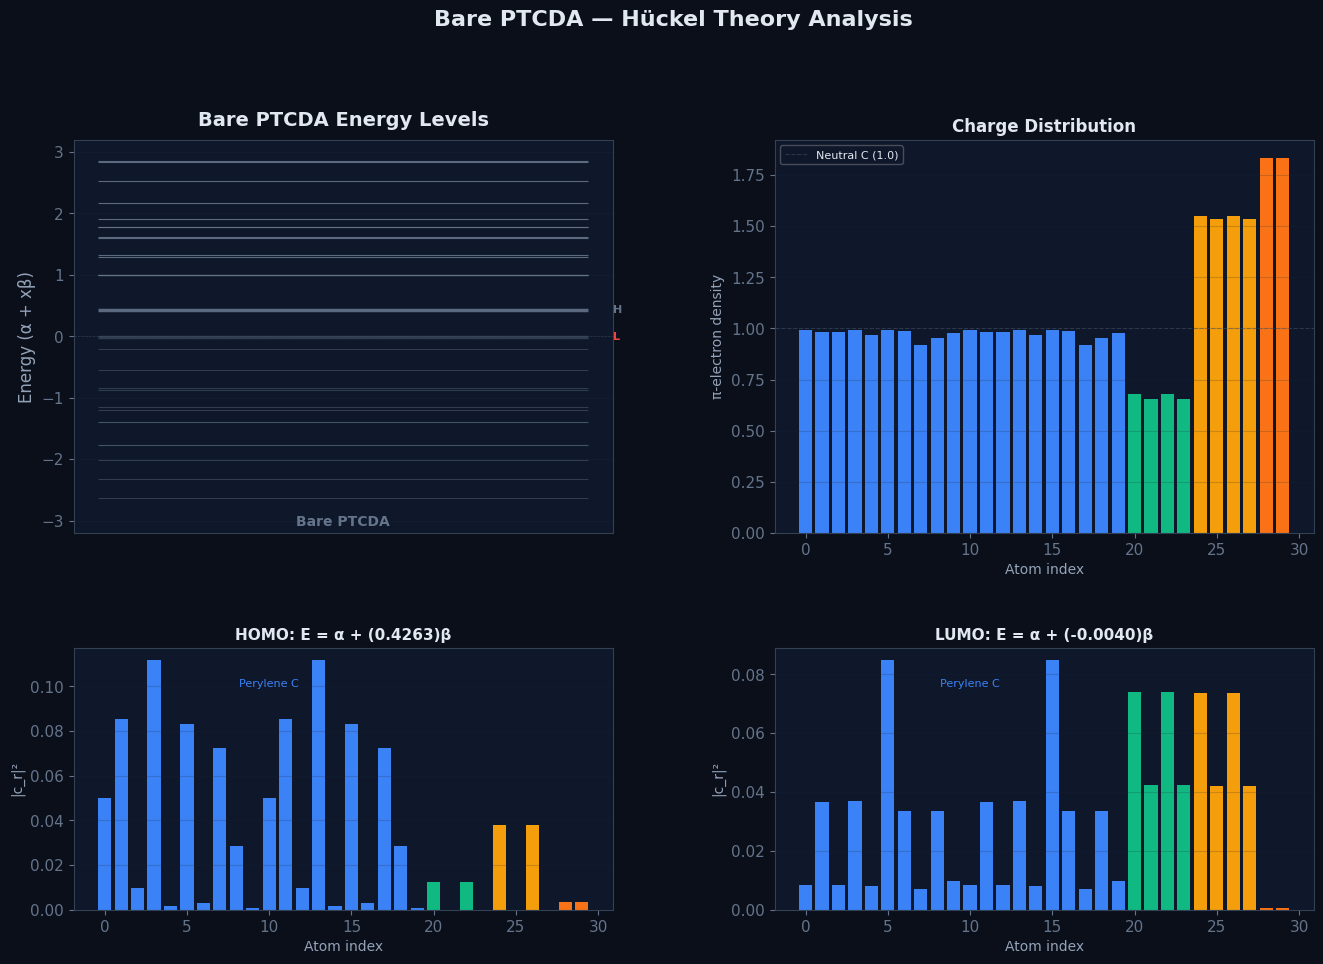

In [6]:
# Visualize bare PTCDA
fig = plt.figure(figsize=(16, 10))
gs = gridspec.GridSpec(2, 2, height_ratios=[1.5, 1], hspace=0.35, wspace=0.3)

ax1 = fig.add_subplot(gs[0, 0])
plot_energy_levels({'Bare PTCDA': bare_result}, ax=ax1, title='Bare PTCDA Energy Levels')

ax2 = fig.add_subplot(gs[0, 1])
plot_charge_distribution(bare_result, ax=ax2)

ax3 = fig.add_subplot(gs[1, 0])
plot_wavefunction(bare_result, bare_result['homo_idx'], ax=ax3)

ax4 = fig.add_subplot(gs[1, 1])
plot_wavefunction(bare_result, bare_result['lumo_idx'], ax=ax4)

plt.suptitle('Bare PTCDA — Hückel Theory Analysis', fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

## 6. Fe/PTCDA — Decomposing Orbital Shifts

Now the core analysis: we compute HOMO shifts from three scenarios and compare:

| Scenario | β_Fe-O | Δα | What it captures |
|----------|--------|-----|------------------|
| **Bare** | 0 | 0 | Reference |
| **Deloc. only** | ≠ 0 | 0 | Orbital mixing (covalent bond) |
| **Electro. only** | 0 | ≠ 0 | Coulomb potential shift |
| **Full** | ≠ 0 | ≠ 0 | Both effects combined |

In [7]:
def run_decomposition(alpha_fe=1.0, beta_fe_o=0.7, delta_alpha=0.2,
                       n_fe=2, beta_eV=-2.4, verbose=True):
    """
    Run full decomposition analysis:
    Bare → Delocalization only → Electrostatic only → Full

    Parameters
    ----------
    alpha_fe : float
        Fe on-site energy (units of β)
    beta_fe_o : float
        Fe-O resonance integral ratio
    delta_alpha : float
        Electrostatic shift on anhydride atoms
    n_fe : int
        Number of Fe atoms
    beta_eV : float
        β value in eV for energy scale calibration
    """
    n_elec_full = N_ELECTRONS_PTCDA + n_fe * 2  # Fe contributes 2 e⁻ each

    # 1. Bare PTCDA
    H_bare = build_ptcda_matrix()
    res_bare = solve_huckel(H_bare, N_ELECTRONS_PTCDA)

    # 2. Delocalization only (Fe atoms, but no electrostatic shift)
    H_deloc, N_deloc = build_metal_ptcda_matrix(alpha_fe, beta_fe_o, 0.0, n_fe)
    res_deloc = solve_huckel(H_deloc, n_elec_full)

    # 3. Electrostatic only (no Fe atoms, just Δα on PTCDA)
    H_electro = build_ptcda_matrix(delta_alpha, ELECTROSTATIC_ATOMS)
    res_electro = solve_huckel(H_electro, N_ELECTRONS_PTCDA)

    # 4. Full (both effects)
    H_full, N_full = build_metal_ptcda_matrix(alpha_fe, beta_fe_o, delta_alpha, n_fe)
    res_full = solve_huckel(H_full, n_elec_full)

    # Compute shifts
    homo_bare = res_bare['homo_energy']
    shift_deloc = res_deloc['homo_energy'] - homo_bare
    shift_electro = res_electro['homo_energy'] - homo_bare
    shift_full = res_full['homo_energy'] - homo_bare

    lumo_bare = res_bare['lumo_energy']
    shift_lumo_full = res_full['lumo_energy'] - lumo_bare

    gap_bare = res_bare['gap']
    gap_full = res_full['gap']

    if verbose:
        print('=' * 70)
        print(f'Fe/PTCDA Hückel Decomposition (n_Fe={n_fe})')
        print(f'Parameters: α_Fe={alpha_fe:.2f}, β_Fe-O={beta_fe_o:.2f}, Δα={delta_alpha:.2f}')
        print('=' * 70)
        print(f'                      HOMO (xβ)    Shift (β)    Shift (eV)')
        print(f'  Bare PTCDA:         {homo_bare:+.4f}       ---          ---')
        print(f'  Deloc. only:        {res_deloc["homo_energy"]:+.4f}      {shift_deloc:+.4f}      {shift_deloc*beta_eV:+.3f}')
        print(f'  Electro. only:      {res_electro["homo_energy"]:+.4f}      {shift_electro:+.4f}      {shift_electro*beta_eV:+.3f}')
        print(f'  Full (both):        {res_full["homo_energy"]:+.4f}      {shift_full:+.4f}      {shift_full*beta_eV:+.3f}')
        print(f'  ---')
        print(f'  Sum of parts:       ---           {shift_deloc+shift_electro:+.4f}      {(shift_deloc+shift_electro)*beta_eV:+.3f}')
        print(f'  Non-additivity:     ---           {shift_full-(shift_deloc+shift_electro):+.4f}      {(shift_full-(shift_deloc+shift_electro))*beta_eV:+.3f}')
        print()
        print(f'  LUMO shift (full):  {shift_lumo_full:+.4f} β  =  {shift_lumo_full*beta_eV:+.3f} eV')
        print(f'  Gap: {gap_bare:.4f} → {gap_full:.4f} |β|  (Δ = {gap_full-gap_bare:+.4f})')

    return {
        'bare': res_bare,
        'deloc': res_deloc,
        'electro': res_electro,
        'full': res_full,
        'shifts': {
            'homo_deloc': shift_deloc,
            'homo_electro': shift_electro,
            'homo_full': shift_full,
            'lumo_full': shift_lumo_full,
            'gap_change': gap_full - gap_bare,
        },
        'params': {
            'alpha_fe': alpha_fe, 'beta_fe_o': beta_fe_o,
            'delta_alpha': delta_alpha, 'n_fe': n_fe, 'beta_eV': beta_eV,
        }
    }

In [8]:
# Run with default Fe parameters
results = run_decomposition(
    alpha_fe=1.0,    # Fe on-site energy
    beta_fe_o=0.7,   # Fe-O coupling
    delta_alpha=0.2, # Electrostatic shift
    n_fe=2,          # 2 Fe atoms (one per anhydride)
    beta_eV=-2.4,    # Energy scale
)

Fe/PTCDA Hückel Decomposition (n_Fe=2)
Parameters: α_Fe=1.00, β_Fe-O=0.70, Δα=0.20
                      HOMO (xβ)    Shift (β)    Shift (eV)
  Bare PTCDA:         +0.4263       ---          ---
  Deloc. only:        +0.1963      -0.2300      +0.552
  Electro. only:      +0.4785      +0.0522      -0.125
  Full (both):        +0.2819      -0.1444      +0.347
  ---
  Sum of parts:       ---           -0.1778      +0.427
  Non-additivity:     ---           +0.0334      -0.080

  LUMO shift (full):  +0.1350 β  =  -0.324 eV
  Gap: 0.4303 → 0.1509 |β|  (Δ = -0.2794)


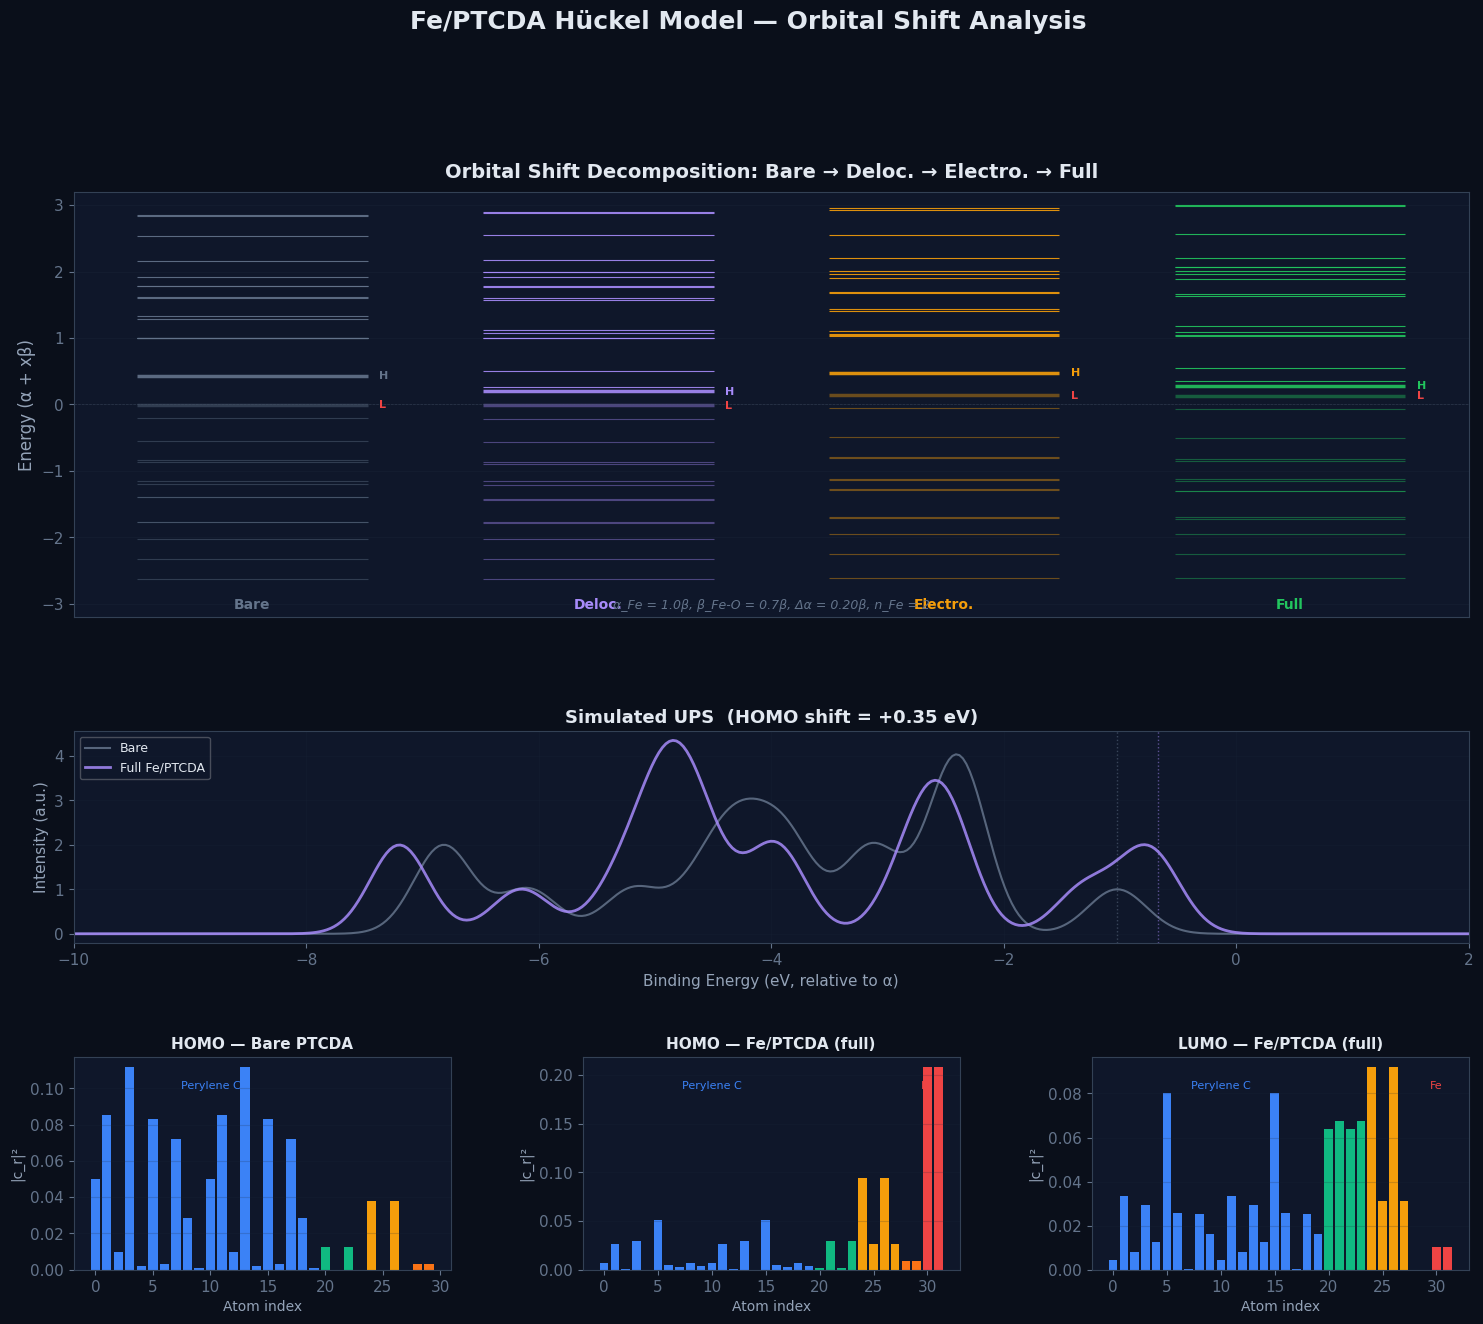

In [9]:
# === Full decomposition visualization ===

fig = plt.figure(figsize=(18, 14))
gs = gridspec.GridSpec(3, 3, height_ratios=[1.6, 0.8, 0.8], hspace=0.4, wspace=0.35)

# Panel 1: Energy level comparison (all 4 scenarios)
ax1 = fig.add_subplot(gs[0, :])
plot_energy_levels(
    {'Bare': results['bare'], 'Deloc.': results['deloc'],
     'Electro.': results['electro'], 'Full': results['full']},
    ax=ax1, title='Orbital Shift Decomposition: Bare → Deloc. → Electro. → Full'
)

# Annotate shifts
p = results['params']
s = results['shifts']
info = (f'α_Fe = {p["alpha_fe"]:.1f}β, β_Fe-O = {p["beta_fe_o"]:.1f}β, '
        f'Δα = {p["delta_alpha"]:.2f}β, n_Fe = {p["n_fe"]}')
ax1.text(0.5, 0.02, info, transform=ax1.transAxes, ha='center',
         fontsize=9, color='#64748b', style='italic')

# Panel 2: Simulated photoemission
ax2 = fig.add_subplot(gs[1, :])
plot_simulated_spectrum(
    {'Bare': results['bare'], 'Full Fe/PTCDA': results['full']},
    beta_eV=p['beta_eV'], ax=ax2,
    title=f'Simulated UPS  (HOMO shift = {s["homo_full"]*p["beta_eV"]:+.2f} eV)'
)

# Panel 3: HOMO wavefunctions
ax3 = fig.add_subplot(gs[2, 0])
plot_wavefunction(results['bare'], results['bare']['homo_idx'],
                  ax=ax3, title='HOMO — Bare PTCDA')

ax4 = fig.add_subplot(gs[2, 1])
plot_wavefunction(results['full'], results['full']['homo_idx'],
                  n_fe=p['n_fe'], ax=ax4, title='HOMO — Fe/PTCDA (full)')

ax5 = fig.add_subplot(gs[2, 2])
plot_wavefunction(results['full'], results['full']['lumo_idx'],
                  n_fe=p['n_fe'], ax=ax5, title='LUMO — Fe/PTCDA (full)')

plt.suptitle('Fe/PTCDA Hückel Model — Orbital Shift Analysis',
             fontsize=18, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

## 7. Ag vs Fe Comparison

Now let's directly compare Ag (physisorption) vs Fe (chemisorption) to show why Fe causes much larger orbital shifts.

In [10]:
# Ag: weak physisorption — small β and Δα
res_ag = run_decomposition(
    alpha_fe=0.3,     # Ag has shallow d-band
    beta_fe_o=0.15,   # Very weak orbital overlap
    delta_alpha=0.05, # Minimal electrostatic
    n_fe=2, beta_eV=-2.4,
)
print()

# Fe: strong chemisorption
res_fe = run_decomposition(
    alpha_fe=1.0,     # Fe d-orbital closer to PTCDA levels
    beta_fe_o=0.7,    # Strong covalent bond
    delta_alpha=0.25, # Significant electrostatic
    n_fe=2, beta_eV=-2.4,
)

Fe/PTCDA Hückel Decomposition (n_Fe=2)
Parameters: α_Fe=0.30, β_Fe-O=0.15, Δα=0.05
                      HOMO (xβ)    Shift (β)    Shift (eV)
  Bare PTCDA:         +0.4263       ---          ---
  Deloc. only:        +0.2578      -0.1685      +0.404
  Electro. only:      +0.4398      +0.0135      -0.032
  Full (both):        +0.2608      -0.1655      +0.397
  ---
  Sum of parts:       ---           -0.1551      +0.372
  Non-additivity:     ---           -0.0105      +0.025

  LUMO shift (full):  +0.0345 β  =  -0.083 eV
  Gap: 0.4303 → 0.2302 |β|  (Δ = -0.2001)

Fe/PTCDA Hückel Decomposition (n_Fe=2)
Parameters: α_Fe=1.00, β_Fe-O=0.70, Δα=0.25
                      HOMO (xβ)    Shift (β)    Shift (eV)
  Bare PTCDA:         +0.4263       ---          ---
  Deloc. only:        +0.1963      -0.2300      +0.552
  Electro. only:      +0.4911      +0.0647      -0.155
  Full (both):        +0.3023      -0.1240      +0.298
  ---
  Sum of parts:       ---           -0.1653      +0.397
  Non-addi

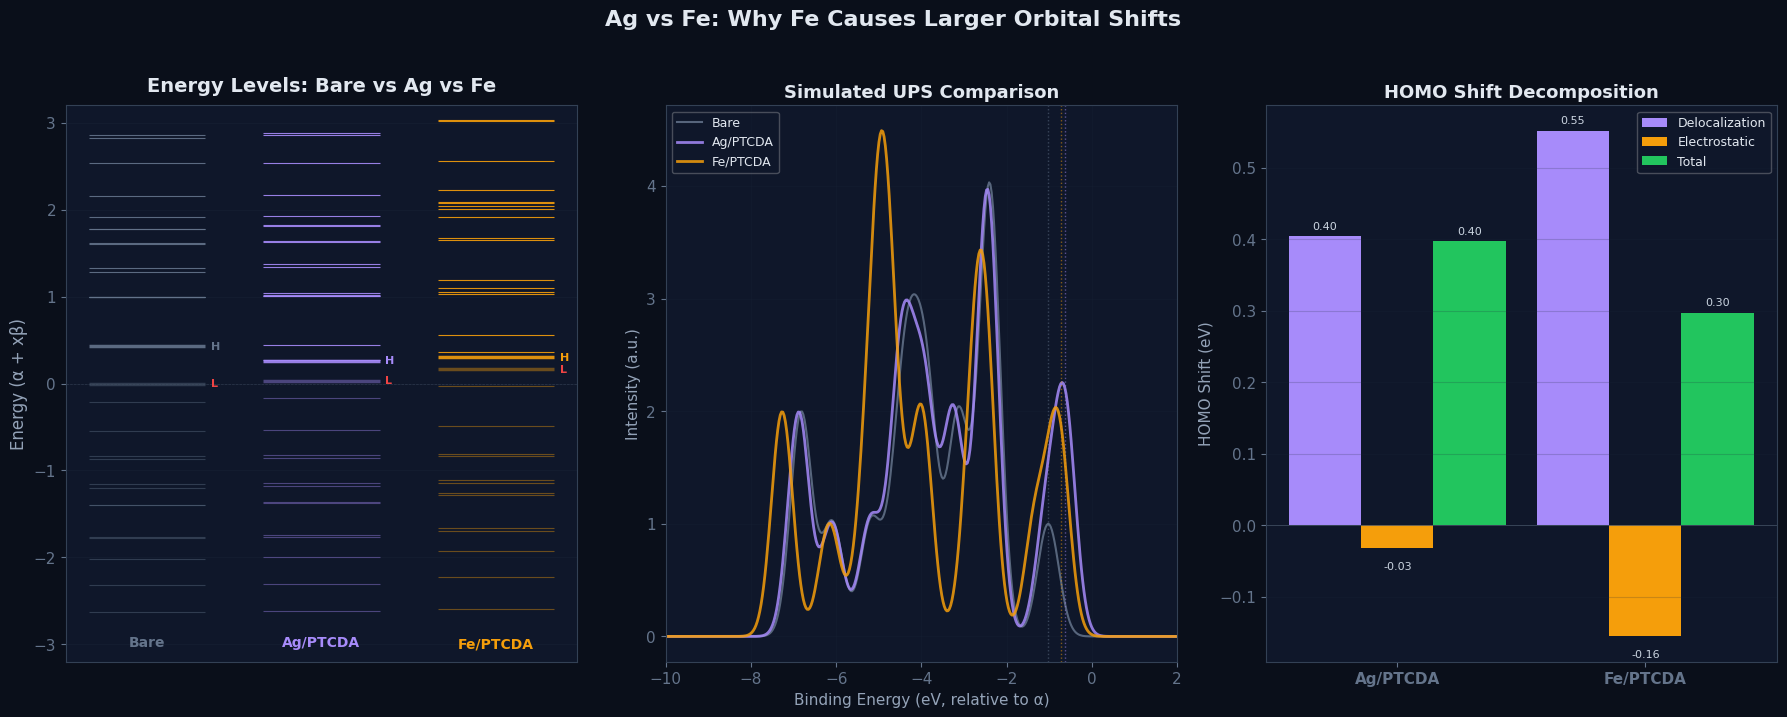

In [11]:
# Ag vs Fe comparison figure
fig, axes = plt.subplots(1, 3, figsize=(18, 7))

# Energy levels
plot_energy_levels(
    {'Bare': res_ag['bare'], 'Ag/PTCDA': res_ag['full'], 'Fe/PTCDA': res_fe['full']},
    ax=axes[0], title='Energy Levels: Bare vs Ag vs Fe'
)

# Spectra overlay
plot_simulated_spectrum(
    {'Bare': res_ag['bare'], 'Ag/PTCDA': res_ag['full'], 'Fe/PTCDA': res_fe['full']},
    beta_eV=-2.4, ax=axes[1],
    title='Simulated UPS Comparison'
)

# Bar chart of shift contributions
ax = axes[2]
x_pos = np.array([0, 1.2])
width = 0.35
beta_eV_val = -2.4

deloc_shifts = [res_ag['shifts']['homo_deloc'] * beta_eV_val,
                res_fe['shifts']['homo_deloc'] * beta_eV_val]
electro_shifts = [res_ag['shifts']['homo_electro'] * beta_eV_val,
                  res_fe['shifts']['homo_electro'] * beta_eV_val]
total_shifts = [res_ag['shifts']['homo_full'] * beta_eV_val,
                res_fe['shifts']['homo_full'] * beta_eV_val]

bars1 = ax.bar(x_pos - width, deloc_shifts, width, label='Delocalization',
               color='#a78bfa', edgecolor='none')
bars2 = ax.bar(x_pos, electro_shifts, width, label='Electrostatic',
               color='#f59e0b', edgecolor='none')
bars3 = ax.bar(x_pos + width, total_shifts, width, label='Total',
               color='#22c55e', edgecolor='none')

ax.set_xticks(x_pos)
ax.set_xticklabels(['Ag/PTCDA', 'Fe/PTCDA'], fontsize=11, fontweight='bold')
ax.set_ylabel('HOMO Shift (eV)', fontsize=11)
ax.set_title('HOMO Shift Decomposition', fontsize=13, fontweight='bold')
ax.legend(fontsize=9, framealpha=0.3)
ax.grid(True, axis='y', alpha=0.2)
ax.axhline(y=0, color='#475569', linewidth=0.5)

# Value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        h = bar.get_height()
        if abs(h) > 0.01:
            ax.text(bar.get_x() + bar.get_width()/2, h + (0.01 if h > 0 else -0.03),
                    f'{h:.2f}', ha='center', fontsize=8, color='#cbd5e1')

plt.suptitle('Ag vs Fe: Why Fe Causes Larger Orbital Shifts',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 8. Parameter Scan — Fitting to Experimental Data

Scan β_Fe-O and Δα to find which parameter combinations reproduce a target experimental HOMO shift.

**Usage:** Set `TARGET_SHIFT_eV` to your experimental value, then run to find the optimal parameter region.

In [12]:
# === PARAMETER SCAN ===
# Adjust these to match your experimental data:

TARGET_SHIFT_eV = -0.5   # Target HOMO shift in eV (negative = shift to higher BE)
ALPHA_FE = 1.0            # Fixed Fe on-site energy
N_FE = 2                  # Number of Fe atoms
BETA_EV = -2.4            # β in eV

# Scan ranges
beta_range = np.linspace(0.0, 1.5, 40)
dalpha_range = np.linspace(-0.2, 0.8, 35)

# Compute HOMO shifts on grid
shift_grid = np.zeros((len(dalpha_range), len(beta_range)))
deloc_grid = np.zeros_like(shift_grid)
electro_grid = np.zeros_like(shift_grid)

bare_homo = bare_result['homo_energy']

print('Scanning parameter space...')
for j, beta_fo in enumerate(beta_range):
    for i, da in enumerate(dalpha_range):
        n_elec = N_ELECTRONS_PTCDA + N_FE * 2

        # Full
        H_full, _ = build_metal_ptcda_matrix(ALPHA_FE, beta_fo, da, N_FE)
        res_full = solve_huckel(H_full, n_elec)
        shift_grid[i, j] = (res_full['homo_energy'] - bare_homo) * BETA_EV

        # Deloc only
        H_d, _ = build_metal_ptcda_matrix(ALPHA_FE, beta_fo, 0.0, N_FE)
        res_d = solve_huckel(H_d, n_elec)
        deloc_grid[i, j] = (res_d['homo_energy'] - bare_homo) * BETA_EV

        # Electro only
        H_e = build_ptcda_matrix(da, ELECTROSTATIC_ATOMS)
        res_e = solve_huckel(H_e, N_ELECTRONS_PTCDA)
        electro_grid[i, j] = (res_e['homo_energy'] - bare_homo) * BETA_EV

print('Done!')

Scanning parameter space...
Done!


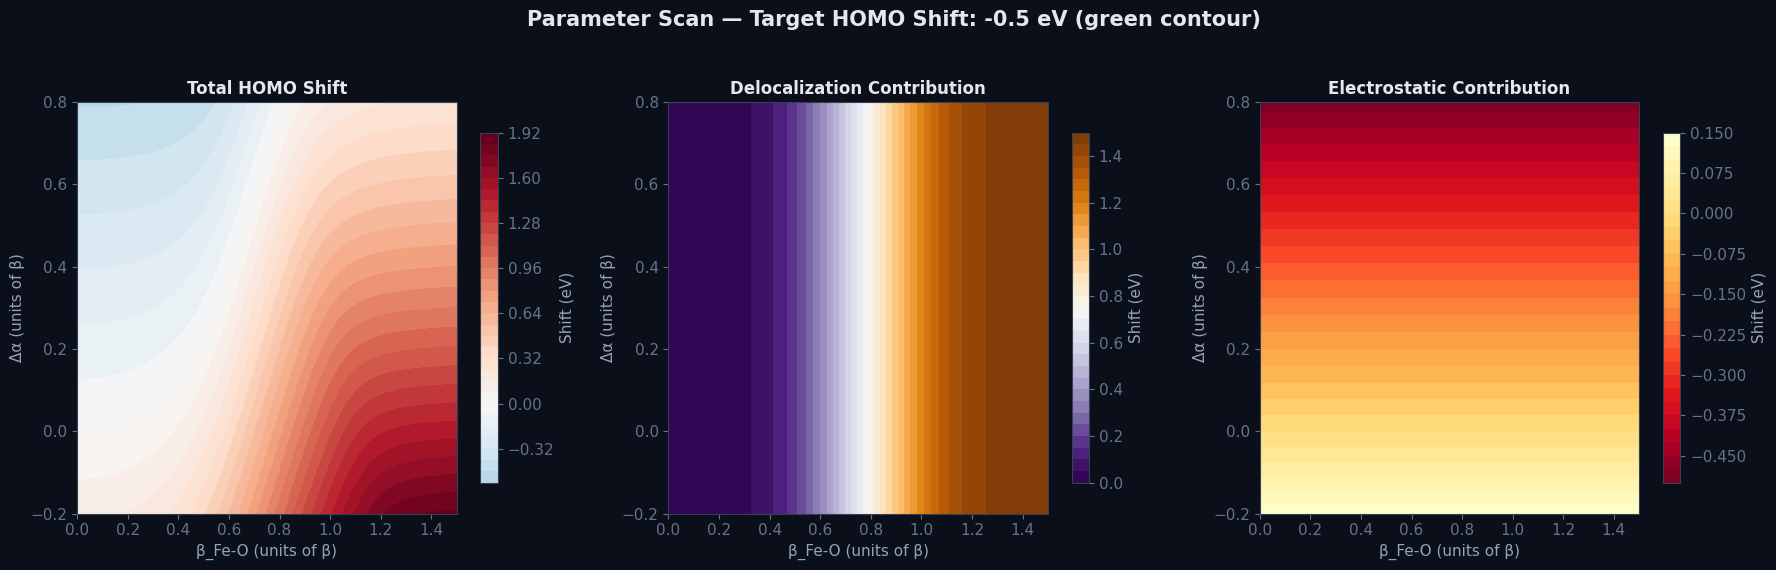


💡 The green contour shows parameter combinations that produce
   a HOMO shift of -0.5 eV — use this to fit your UPS data!


In [13]:
# Visualize parameter scan
fig, axes = plt.subplots(1, 3, figsize=(18, 5.5))

titles = ['Total HOMO Shift', 'Delocalization Contribution', 'Electrostatic Contribution']
grids = [shift_grid, deloc_grid, electro_grid]
cmaps = ['RdBu_r', 'PuOr_r', 'YlOrRd_r']

for idx, (ax, grid, cmap, title) in enumerate(zip(axes, grids, cmaps, titles)):
    vmax = max(abs(grid.min()), abs(grid.max()))
    vmin = -vmax if idx == 0 else grid.min()
    if idx > 0:
        vmax = grid.max()

    im = ax.contourf(beta_range, dalpha_range, grid, levels=30,
                     cmap=cmap, vmin=vmin, vmax=vmax)

    # Target contour
    if idx == 0:
        cs = ax.contour(beta_range, dalpha_range, grid,
                       levels=[TARGET_SHIFT_eV], colors=['#22c55e'],
                       linewidths=2.5)
        ax.clabel(cs, fmt=f'{TARGET_SHIFT_eV:.1f} eV', fontsize=9, colors=['#22c55e'])

    plt.colorbar(im, ax=ax, label='Shift (eV)', shrink=0.85)
    ax.set_xlabel('β_Fe-O (units of β)', fontsize=11)
    ax.set_ylabel('Δα (units of β)', fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')

plt.suptitle(f'Parameter Scan — Target HOMO Shift: {TARGET_SHIFT_eV} eV (green contour)',
             fontsize=15, fontweight='bold', y=1.03)
plt.tight_layout()
plt.show()

print(f'\n💡 The green contour shows parameter combinations that produce')
print(f'   a HOMO shift of {TARGET_SHIFT_eV} eV — use this to fit your UPS data!')

## 9. Interactive Exploration (Colab Widgets)

Use the sliders below to interactively explore how Fe parameters affect HOMO shifts.

**Tip:** Compare the "Decompose" view to see how delocalization and electrostatic effects contribute independently.

In [14]:
# === INTERACTIVE WIDGET ===

style = {'description_width': '130px'}
layout = widgets.Layout(width='450px')

w_alpha_fe = widgets.FloatSlider(
    value=1.0, min=-1.0, max=3.0, step=0.05,
    description='α_Fe (on-site):', style=style, layout=layout,
    readout_format='.2f'
)
w_beta_fo = widgets.FloatSlider(
    value=0.7, min=0.0, max=1.5, step=0.05,
    description='β_Fe-O (coupling):', style=style, layout=layout,
    readout_format='.2f'
)
w_dalpha = widgets.FloatSlider(
    value=0.2, min=-0.5, max=1.0, step=0.02,
    description='Δα (electrostatic):', style=style, layout=layout,
    readout_format='.2f'
)
w_nfe = widgets.IntSlider(
    value=2, min=0, max=4, step=1,
    description='# Fe atoms:', style=style, layout=layout
)
w_beta_ev = widgets.FloatSlider(
    value=-2.4, min=-3.5, max=-1.5, step=0.1,
    description='β (eV):', style=style, layout=layout,
    readout_format='.1f'
)
w_view = widgets.ToggleButtons(
    options=['Compare (Bare vs Full)', 'Decompose (4-column)'],
    value='Decompose (4-column)',
    description='View mode:',
    style=style,
)

# Preset buttons
btn_bare = widgets.Button(description='Bare PTCDA', button_style='', layout=widgets.Layout(width='120px'))
btn_ag = widgets.Button(description='Ag/PTCDA', button_style='info', layout=widgets.Layout(width='120px'))
btn_fe_w = widgets.Button(description='Fe (weak)', button_style='warning', layout=widgets.Layout(width='120px'))
btn_fe_s = widgets.Button(description='Fe (strong)', button_style='danger', layout=widgets.Layout(width='120px'))

def set_preset(alpha, beta, da, nfe):
    w_alpha_fe.value = alpha
    w_beta_fo.value = beta
    w_dalpha.value = da
    w_nfe.value = nfe

btn_bare.on_click(lambda _: set_preset(0, 0, 0, 0))
btn_ag.on_click(lambda _: set_preset(0.3, 0.15, 0.05, 2))
btn_fe_w.on_click(lambda _: set_preset(0.8, 0.5, 0.15, 2))
btn_fe_s.on_click(lambda _: set_preset(1.2, 0.9, 0.35, 4))

output = widgets.Output()

def update_plot(*args):
    with output:
        clear_output(wait=True)

        res = run_decomposition(
            alpha_fe=w_alpha_fe.value,
            beta_fe_o=w_beta_fo.value,
            delta_alpha=w_dalpha.value,
            n_fe=w_nfe.value,
            beta_eV=w_beta_ev.value,
            verbose=True,
        )

        decompose = 'Decompose' in w_view.value

        fig = plt.figure(figsize=(16, 10))
        gs = gridspec.GridSpec(2, 2, height_ratios=[1.4, 1], hspace=0.35, wspace=0.3)

        # Energy levels
        ax1 = fig.add_subplot(gs[0, 0])
        if decompose:
            plot_energy_levels(
                {'Bare': res['bare'], 'Deloc.': res['deloc'],
                 'Electro.': res['electro'], 'Full': res['full']},
                ax=ax1, title='Decomposition'
            )
        else:
            plot_energy_levels(
                {'Bare PTCDA': res['bare'], 'Metal/PTCDA': res['full']},
                ax=ax1, title='Bare vs Metal/PTCDA'
            )

        # Spectrum
        ax2 = fig.add_subplot(gs[0, 1])
        spec_dict = {'Bare': res['bare'], 'Full': res['full']}
        if decompose:
            spec_dict = {'Bare': res['bare'], 'Deloc.': res['deloc'],
                        'Electro.': res['electro'], 'Full': res['full']}
        plot_simulated_spectrum(spec_dict, beta_eV=w_beta_ev.value, ax=ax2)

        # HOMO wavefunction
        ax3 = fig.add_subplot(gs[1, 0])
        plot_wavefunction(res['full'], res['full']['homo_idx'],
                         n_fe=w_nfe.value, ax=ax3, title='HOMO — Full system')

        # LUMO wavefunction
        ax4 = fig.add_subplot(gs[1, 1])
        plot_wavefunction(res['full'], res['full']['lumo_idx'],
                         n_fe=w_nfe.value, ax=ax4, title='LUMO — Full system')

        plt.tight_layout()
        plt.show()

# Connect widgets
for w in [w_alpha_fe, w_beta_fo, w_dalpha, w_nfe, w_beta_ev, w_view]:
    w.observe(update_plot, names='value')

# Layout
preset_box = widgets.HBox([btn_bare, btn_ag, btn_fe_w, btn_fe_s])
control_box = widgets.VBox([
    widgets.HTML('<h3 style="color:#e2e8f0;">🎛️ Fe/PTCDA Hückel Simulator</h3>'),
    preset_box,
    widgets.HTML('<hr style="border-color:#334155;">'),
    w_nfe, w_alpha_fe, w_beta_fo, w_dalpha,
    widgets.HTML('<hr style="border-color:#334155;">'),
    w_beta_ev, w_view,
])

display(control_box)
display(output)
update_plot()  # Initial render

Output()

## 10. Systematic β_Fe-O Dependence

How does the HOMO shift evolve as we increase Fe-O coupling strength?

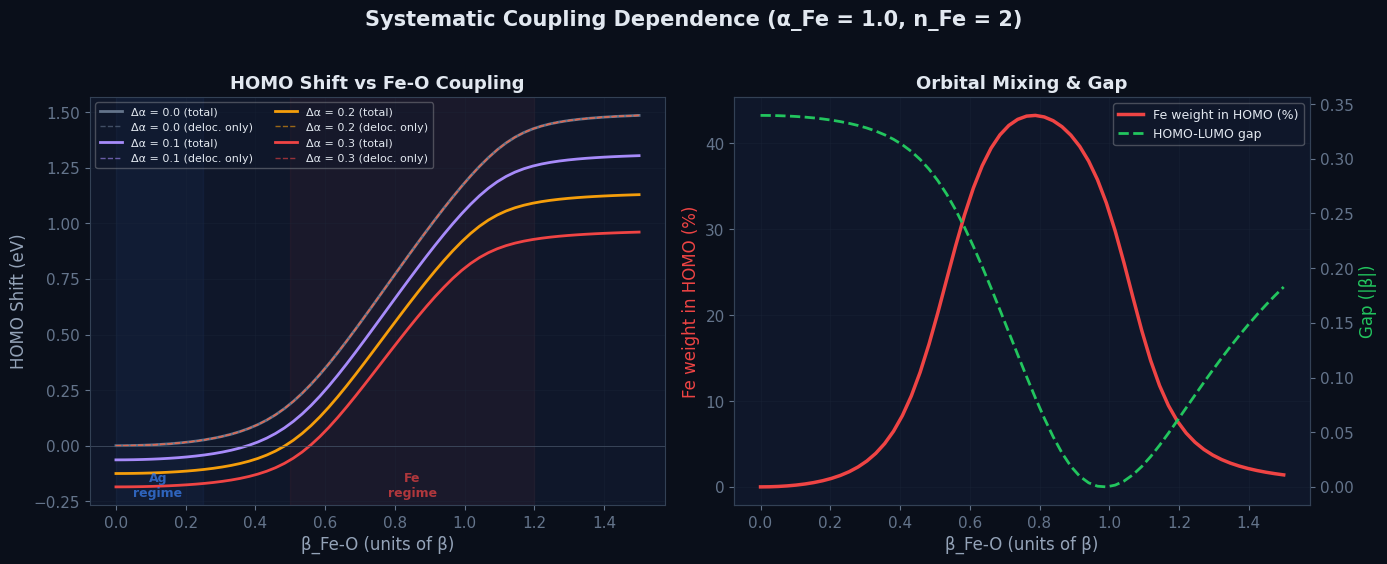

In [15]:
# Scan β_Fe-O at fixed Δα
beta_scan = np.linspace(0, 1.5, 60)
fixed_dalpha_values = [0.0, 0.1, 0.2, 0.3]
fixed_alpha_fe = 1.0
beta_eV_val = -2.4

fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))

# Panel 1: HOMO shift vs β_Fe-O for different Δα
ax = axes[0]
colors_da = ['#64748b', '#a78bfa', '#f59e0b', '#ef4444']

for da, color in zip(fixed_dalpha_values, colors_da):
    shifts_deloc = []
    shifts_total = []

    for b in beta_scan:
        n_elec = N_ELECTRONS_PTCDA + 4  # 2 Fe × 2 e
        # Full
        H_f, _ = build_metal_ptcda_matrix(fixed_alpha_fe, b, da, 2)
        r_f = solve_huckel(H_f, n_elec)
        shifts_total.append((r_f['homo_energy'] - bare_homo) * beta_eV_val)

        # Deloc only
        H_d, _ = build_metal_ptcda_matrix(fixed_alpha_fe, b, 0.0, 2)
        r_d = solve_huckel(H_d, n_elec)
        shifts_deloc.append((r_d['homo_energy'] - bare_homo) * beta_eV_val)

    ax.plot(beta_scan, shifts_total, color=color, linewidth=2,
            label=f'Δα = {da:.1f} (total)')
    ax.plot(beta_scan, shifts_deloc, color=color, linewidth=1, linestyle='--',
            alpha=0.6, label=f'Δα = {da:.1f} (deloc. only)')

ax.set_xlabel('β_Fe-O (units of β)', fontsize=12)
ax.set_ylabel('HOMO Shift (eV)', fontsize=12)
ax.set_title('HOMO Shift vs Fe-O Coupling', fontsize=13, fontweight='bold')
ax.legend(fontsize=8, framealpha=0.3, ncol=2)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='#475569', linewidth=0.5)

# Annotate Ag vs Fe regime
ax.axvspan(0, 0.25, alpha=0.05, color='#3b82f6')
ax.axvspan(0.5, 1.2, alpha=0.05, color='#ef4444')
ax.text(0.12, ax.get_ylim()[0]*0.85, 'Ag\nregime', ha='center',
        fontsize=9, color='#3b82f6', fontweight='bold', alpha=0.7)
ax.text(0.85, ax.get_ylim()[0]*0.85, 'Fe\nregime', ha='center',
        fontsize=9, color='#ef4444', fontweight='bold', alpha=0.7)

# Panel 2: Fe weight in HOMO vs β_Fe-O
ax2 = axes[1]
fe_weights = []
gaps = []

for b in beta_scan:
    n_elec = N_ELECTRONS_PTCDA + 4
    H_f, _ = build_metal_ptcda_matrix(fixed_alpha_fe, b, 0.2, 2)
    r_f = solve_huckel(H_f, n_elec)

    # Fe weight in HOMO = sum of |c|^2 on Fe atoms
    vec = r_f['eigenvectors'][:, r_f['homo_idx']]
    fe_w = np.sum(vec[30:]**2)  # atoms 30+ are Fe
    fe_weights.append(fe_w * 100)
    gaps.append(r_f['gap'])

ax2.plot(beta_scan, fe_weights, color='#ef4444', linewidth=2.5, label='Fe weight in HOMO (%)')
ax2_twin = ax2.twinx()
ax2_twin.plot(beta_scan, gaps, color='#22c55e', linewidth=2, linestyle='--', label='HOMO-LUMO gap')

ax2.set_xlabel('β_Fe-O (units of β)', fontsize=12)
ax2.set_ylabel('Fe weight in HOMO (%)', fontsize=12, color='#ef4444')
ax2_twin.set_ylabel('Gap (|β|)', fontsize=12, color='#22c55e')
ax2.set_title('Orbital Mixing & Gap', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_twin.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, fontsize=9, framealpha=0.3)

plt.suptitle('Systematic Coupling Dependence (α_Fe = 1.0, n_Fe = 2)',
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 11. Customize: Your Own Parameters

Edit the cell below with your own parameters to match experimental binding energies.

In [16]:
# ╔══════════════════════════════════════════════╗
# ║   CUSTOMIZE YOUR PARAMETERS HERE             ║
# ╚══════════════════════════════════════════════╝

MY_PARAMS = {
    'alpha_fe': 1.0,     # Fe on-site energy relative to C (units of β)
    'beta_fe_o': 0.7,    # Fe-O resonance integral (units of β)
    'delta_alpha': 0.20, # Electrostatic shift (units of β)
    'n_fe': 2,           # Number of Fe atoms
    'beta_eV': -2.4,     # β in eV (energy scale calibration)
}

# Optional: custom binding sites
# Each Fe bonds to specific PTCDA atoms.
# Default: Fe → carbonyl oxygens (atoms 24,25,26,27)
# Uncomment to customize:
# MY_BINDING_SITES = [[24, 25], [26, 27]]  # Fe₁→O24,O25; Fe₂→O26,O27

# Run
my_results = run_decomposition(**MY_PARAMS)

# Quick summary
print(f'\n{"="*50}')
print(f'  HOMO shift: {my_results["shifts"]["homo_full"]*MY_PARAMS["beta_eV"]:+.3f} eV')
print(f'    ├─ Delocalization: {my_results["shifts"]["homo_deloc"]*MY_PARAMS["beta_eV"]:+.3f} eV')
print(f'    └─ Electrostatic:  {my_results["shifts"]["homo_electro"]*MY_PARAMS["beta_eV"]:+.3f} eV')
print(f'  LUMO shift: {my_results["shifts"]["lumo_full"]*MY_PARAMS["beta_eV"]:+.3f} eV')
print(f'  Gap change: {my_results["shifts"]["gap_change"]*abs(MY_PARAMS["beta_eV"]):+.3f} eV')
print(f'{"="*50}')

Fe/PTCDA Hückel Decomposition (n_Fe=2)
Parameters: α_Fe=1.00, β_Fe-O=0.70, Δα=0.20
                      HOMO (xβ)    Shift (β)    Shift (eV)
  Bare PTCDA:         +0.4263       ---          ---
  Deloc. only:        +0.1963      -0.2300      +0.552
  Electro. only:      +0.4785      +0.0522      -0.125
  Full (both):        +0.2819      -0.1444      +0.347
  ---
  Sum of parts:       ---           -0.1778      +0.427
  Non-additivity:     ---           +0.0334      -0.080

  LUMO shift (full):  +0.1350 β  =  -0.324 eV
  Gap: 0.4303 → 0.1509 |β|  (Δ = -0.2794)

  HOMO shift: +0.347 eV
    ├─ Delocalization: +0.552 eV
    └─ Electrostatic:  -0.125 eV
  LUMO shift: -0.324 eV
  Gap change: -0.671 eV


---

## Physical Interpretation Guide

### Hückel Parameters → Physical Meaning

| Parameter | Symbol | Physical origin | Typical values |
|-----------|--------|----------------|----------------|
| Fe on-site energy | α_Fe | Fe d-orbital energy relative to C 2pz | 0.5–1.5 β |
| Fe-O coupling | β_Fe-O | Orbital overlap (bond strength) | Ag: ~0.1β, Fe: ~0.5–1.0β |
| Electrostatic shift | Δα | Madelung-like potential from Fe charge | 0.05–0.35β |

### Key Physics

- **Ag/PTCDA**: Van der Waals bonding → β_Fe-O ≈ 0, Δα ≈ 0 → minimal shifts (physisorption)
- **Fe/PTCDA**: Covalent Fe-O bond → large β_Fe-O → significant orbital mixing + electrostatic shift (chemisorption)
- **HOMO shift**: Observable in UPS (ultraviolet photoemission spectroscopy) as binding energy change
- **Non-additivity**: When both effects are strong, they interact (the total ≠ sum of parts), indicating coupled physics

### Limitations of Hückel Theory

- No electron-electron repulsion → quantitative gap values are approximate
- Single-orbital per atom → doesn't capture full Fe d-manifold
- σ-π separation assumed → charge transfer may be underestimated
- For quantitative fitting: use as simplified framework, calibrate β to experimental data